## INF2209 COVID-19 Vaccine Twitter Topic Modelling

In [1]:
import numpy as np
import pandas as pd
import html
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models


from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

/Users/stephaniezhou/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load dataset
data obtained from Kaggle: https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
# load the datastet obtained from kaggle
df = pd.read_csv('vaccination_all_tweets.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222403 entries, 0 to 222402
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                222403 non-null  int64 
 1   user_name         222402 non-null  object
 2   user_location     157299 non-null  object
 3   user_description  206192 non-null  object
 4   user_created      222403 non-null  object
 5   user_followers    222403 non-null  int64 
 6   user_friends      222403 non-null  int64 
 7   user_favourites   222403 non-null  int64 
 8   user_verified     222403 non-null  bool  
 9   date              222403 non-null  object
 10  text              222403 non-null  object
 11  hashtags          173757 non-null  object
 12  source            222284 non-null  object
 13  retweets          222403 non-null  int64 
 14  favorites         222403 non-null  int64 
 15  is_retweet        222403 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
# load the meta data and extract out fields that will be useful to our application
df = df[['user_location','date','text','hashtags']]
df = df.drop_duplicates(subset='text', keep="first")
#df = df.dropna()
df["text"] = df["text"].str.lower()
df.reset_index(inplace=True, drop=True)
df.head()

,user_location,date,text,hashtags
0,"La Crescenta-Montrose, CA",2020-12-20 06:06:44,same folks said daikon paste could treat a cytokine storm #pfizerbiontech https://t.co/xehhimg1kf,['PfizerBioNTech']
1,"San Francisco, CA",2020-12-13 16:27:13,"while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlchrzjkhm",NaN
2,Your Bed,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbiontech #moderna #covid_19 russian vaccine is created to last 2-4 years… https://t.co/ieylckbr8p,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']"
3,"Vancouver, BC - Canada",2020-12-12 20:23:59,"facts are immutable, senator, even when you're not ethically sturdy enough to acknowledge them. (1) you were born i… https://t.co/jqgv18kch4",NaN
4,NaN,2020-12-12 20:17:19,explain to me again why we need a vaccine @borisjohnson @matthancock #whereareallthesickpeople #pfizerbiontech… https://t.co/kxbsrobehq,"['whereareallthesickpeople', 'PfizerBioNTech']"


In [5]:
df.shape

(220583, 4)

## Data Cleaning:

Twitter tweets contain urls, hashtags (#), mention symbols and potentially html symbols (@) besides punctuations and stop words in other text forms. 
Therefore, text cleaning involves: 
- remove html symbols
- convert html character codes to ASCII
- remove urls
- convert to lowercase
- remove all `STOPWORDS`, can add some custom stop words using nltk
- remove all punctuations including # and @

In [6]:
# convert html character codes to ASCII
df['clean_text'] = df['text'].apply(lambda x: html.unescape(x))

In [7]:
# remove urls
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"http\S+", "", x))

In [8]:
# remove stop words
stop = stopwords.words('english')
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [9]:
# remove all punctuations including # and @, only keep keywords after hashtags and mentions
df['clean_text'] = df['clean_text'].str.replace('[^\w\s\...]','')
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('...',' '))
df['clean_text'] = df['clean_text'].apply(lambda x: x.replace('_',''))

In [10]:
df['clean_text'][3]

'facts immutable senator even ethically sturdy enough acknowledge them. 1 born i'

In [11]:
# convert date to year-month
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_location,date,text,hashtags,clean_text
0,"La Crescenta-Montrose, CA",2020-12-20,same folks said daikon paste could treat a cytokine storm #pfizerbiontech https://t.co/xehhimg1kf,['PfizerBioNTech'],folks said daikon paste could treat cytokine storm pfizerbiontech
1,"San Francisco, CA",2020-12-13,"while the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlchrzjkhm",NaN,world wrong side history year hopefully biggest vaccination effort weve ev
2,Your Bed,2020-12-12,#coronavirus #sputnikv #astrazeneca #pfizerbiontech #moderna #covid_19 russian vaccine is created to last 2-4 years… https://t.co/ieylckbr8p,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",coronavirus sputnikv astrazeneca pfizerbiontech moderna covid19 russian vaccine created last 24 years
3,"Vancouver, BC - Canada",2020-12-12,"facts are immutable, senator, even when you're not ethically sturdy enough to acknowledge them. (1) you were born i… https://t.co/jqgv18kch4",NaN,facts immutable senator even ethically sturdy enough acknowledge them. 1 born i
4,NaN,2020-12-12,explain to me again why we need a vaccine @borisjohnson @matthancock #whereareallthesickpeople #pfizerbiontech… https://t.co/kxbsrobehq,"['whereareallthesickpeople', 'PfizerBioNTech']",explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech


In [12]:
df['clean_text']

0                                             folks said daikon paste could treat cytokine storm pfizerbiontech
1                                    world wrong side history year hopefully biggest vaccination effort weve ev
2         coronavirus sputnikv astrazeneca pfizerbiontech moderna covid19 russian vaccine created last 24 years
3                               facts immutable senator even ethically sturdy enough acknowledge them. 1 born i
4                         explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech
                                                          ...                                                  
220578       45 urban bengaluru covidvaccine availability 0411 0930am free slots 0 paid slots covishield  dose1
220579           covid19 sputnik jab proves ineffective resistant russians sputnik sputnikv russiancovidvaccine
220580         1844 bbmp bengaluru covidvaccine availability 0411 0900am free slots covishield  dose1276

## Exploratory Data Analysis

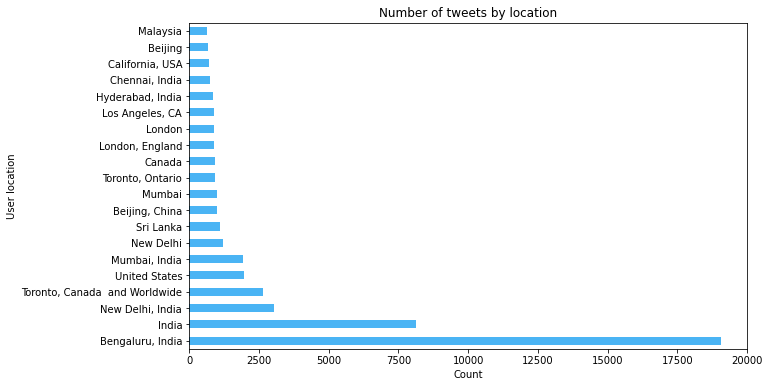

In [13]:
# Visualize tweet count vs location
plt.figure(figsize=(10,6))
df['user_location'].value_counts().nlargest(20).plot(kind='barh', color='#1DA1F2', alpha=0.8)
plt.xlabel('Count')
plt.ylabel('User location')
plt.title('Number of tweets by location')
plt.show()

### Visualization on the vaccine tweets: Word Cloud

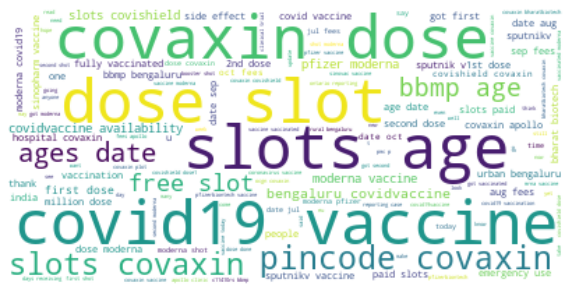

In [14]:
# create a word cloud to visualize the most frequent key words in the vaccine tweets
plt.figure(figsize=(10,8))
text = " ".join(twt for twt in df['clean_text'])
stopwords = set(STOPWORDS)
#stopwords.update(["vaccine"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Models: Topic modelling using Latent Dirichlet Allocation (LDA) and NMF


### Tokenization: Create Bigram and Trigram Models

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.clean_text.values.tolist()
data_words = list(sent_to_words(data))

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['anyone', 'useful', 'adviceguidance', 'whether', 'covid', 'vaccine', 'safe', 'whilst', 'breastfeeding']


In [19]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'slots', 'vaccine','use','ages'])


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [23]:
# remove stop words in addition to the normal english stopwords
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[5:][0][:30])

['anyone', 'useful', 'adviceguidance', 'whether', 'safe', 'whilst', 'breastfeed']


In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[5:][0][:30])

[(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)]
